# ARC validation 2022



This notebook contains code and example runs to provide ARC estimates of a set of biophsycial variables over time, given a set of Sentinel-2 MSI observations. The approach is generalisable to other sensors, but that is not done here. Details of the approach are given in Feng et al. (2024).

The notebook also provides codes to show how to obtain and use the ground measurements collected as a part of this project. The measurements are available in the file [SF_2022_samples_corrected_parsed.geojson](SF_2022_samples_corrected_parsed.geojson).

In section 1., we set (broad) parameters for the runs and define the driving file names. We also install and test codes.

In section 2., we explore the observational dataset, looking at the target field and surrounding area, visualising this as NDVI and rewal colour (RGB).

In section 3., we run the `arc` code to fit the archetype models to each pixel of the observations over the target field. The direct output of this is a matching of measured and (archtype-)modelled reflectance. Additionally, we have knowledge of the model biophysical parameters. We can derive per-pixel uncertainties for these, but here we look only at variation within the plot.

In section 4, we compare the modelled LAI values with fieldwork-measured values. In section 5, we do the same for Chlorophyll concentration. The datasets for modelled and measured biophysical parameters are stored in data files so we can later analyse all datasets together.

Section 6 provides a brief summary of the experiment. 



## 1. Requirements

First, we need to install required codes and datafiles.

### 1.1 tags and parameters

first, we define some tags and parameters for this notebook. These will be used to define filenames associated with this run. 


In [52]:
from pathlib import Path
import pkgutil
import geojson
from shapely import geometry
import pylab as plt
import datetime
import ee
import geojson
import numpy as np
import matplotlib.pyplot as plt
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings

warnings.filterwarnings('ignore') 
format = '%Y-%m-%d'

In [53]:
# filename tag
TAG = 'SF_2022'

# buffer extent for visiualisation, in degrees
dx,dy = 0.009,0.009

# dates
start_date = "2022-08-01"
end_date = "2022-12-10"

# Constants
CROP_TYPE = "wheat"

NUM_SAMPLES = 1000000
LAZY_EVALUATION_STEP = 100

# buffer control
buffer_n = 3


These are ARC parameters. 

The parameters are set to be appropriate for the crop under study (wheat). The time taken to process depends heavily on `NUM_SAMPLES` which controls the number of ensemble members used in the evaluation. Typically `100000` would be sufficient to estimate the mean behaviour. Estimating uncertainty typically requires more members. We use `1000000` here as a default to ensure we get a good solution. This will take around 5 minutes to process, so if you are impatient to proceed, reduce the value of `NUM_SAMPLES`.

Below, we suppose the **crop emergence** to be around 1 month after `start_date` and the **growth season length** (period to peak LAI) to be up to 2 months before the end date. These are just approximate vcalues to help- constrain the solution. 

In [54]:
t0 = int(datetime.datetime.strptime(start_date, format).strftime("%j"))
t1 = int(datetime.datetime.strptime(end_date, format).strftime("%j"))
year = int(datetime.datetime.strptime(start_date, format).strftime("%Y"))

# vary with time period set
#START_OF_SEASON = 240
#GROWTH_SEASON_LENGTH = 45
START_OF_SEASON = t0 + 30
GROWTH_SEASON_LENGTH = t1 - 60 - START_OF_SEASON

print(f'start of data: DOY {t0}, length: {t1-t0} days')
print(f'start of crop: DOY {START_OF_SEASON}, length: {GROWTH_SEASON_LENGTH} days')

start of data: DOY 213, length: 131 days
start of crop: DOY 243, length: 41 days


**We require that two files:**

    files/{TAG}_samples_corrected_parsed.geojson
    files/{TAG}.geojson
    
**exists to drive the notebook.**

The first defines sample locations and measurement data. The second defined the extent of the particular field of interest.

In [55]:
geojson_path= f'files/{TAG}.geojson'
# field
if not Path(geojson_path).exists():
    print(f"required geojson file {geojson_path} does not exists: please create it and re-run")
    exit() 
    
# samples
samplefile= f'files/{TAG}_samples_corrected_parsed.geojson'
if not Path(samplefile).exists():
    print(f"required samples file {samplefile} does not exists: please create it and re-run")
    exit() 

### 1.2 Install ARC code

The ARC code accesses the satellite data and fits the archetype models from Feng et al. (2024).

In [56]:
# install required code: In case of problems, check the log files generated
if pkgutil.find_loader('arc') is None:
    !(pip install https://github.com/MarcYin/ARC/archive/refs/heads/main.zip > arc_install.log) \
          &> arc_install_stderr.log

### 1.3 Set Google EarthEngine credentials


Note that the **first** time you run this notebook, you need to run the `ee.Authenticate()` command and log in with google Earth Engine. This will divert you to a google login page. You may have to 'continue' through an unverified page (`Google hasn’t verified this app`). When asked `Select what Earth Engine Notebook Client - dr.myname@gmail.com can access`, use `select all`. Then you should eventually arrive at an `Authorization code`, which will request you to `Please copy this code, switch to your application and paste it there:`. So, then copy the code and paste below.

In [57]:
# N.B. the first time you run this, it will run the ee.Authenticate() command
# after that, there shouyld be an authfile with -rw-------
authfile=Path('~/.config/earthengine/credentials').expanduser()
if not authfile.exists(): 
    ee.Authenticate()

### 1.4 Set json files for area required

We need to define two [`geojson`-format file](https://geojson.org) to descibe the area of interest. The first defines a local set of coordinates (e.g. sample locations) to explore, and should be called `{TAG}.geojson`, where `TAG` defines the particular dataset of interest, e.g. [`{TAG}_samples_corrected_parsed.geojson`](files/{TAG}_samples_corrected_parsed.geojson). 

We need here to parse the location file [`{TAG}_samples_corrected_parsed.geojson`](files/{TAG}_samples_corrected_parsed.geojson) and set a buffer around it (controlled by `dx,dy = 0.009,0.009` below) to extract a wider area for data visualisation. This produces a file `files/wider_area_{TAG}.geojson` with the wider area defined.

In [58]:
# parse the geojson file 
wider_geojson = f"files/wider_area_{TAG}.geojson"

# get extent
with open(geojson_path, 'r') as f: 
    x,y = np.array([feature['geometry']['coordinates'][:2] \
                      for feature in geojson.load(f)['features']]).T
    xmin,xmax,ymin,ymax = x.min()-dx,x.max()+dx,y.min()-dy,y.max()+dy
# form new geojson
s = '{"type":"FeatureCollection","features":[{"type":'+\
    '"Feature","properties":{},"geometry":{"coordinates":'+\
    f'[[[{xmin},{ymax}],[{xmin},{ymin}],'+\
    f'[{xmax},{ymin}],[{xmax},{ymax}],[{xmin},{ymax}]]],'+\
    '"type":"Polygon"}}]}'
print(s,file=Path(wider_geojson).open('w'))
print(f'wider extent [{xmin}:{xmax}] [{ymin}:{ymax}]')

wider extent [28.733087:28.754987] [-26.974568:-26.953093]


### 1.5 sort date formats

Sort and store the date formats

In [59]:
 # convert from string format to datetime format
# plot layout
dt = (datetime.datetime.strptime(end_date, format) - \
        datetime.datetime.strptime(start_date, format))
nx=5
repeat=5
ny=int(dt.days/repeat/nx)+1

## 2 Data exploration

We first obtain and explore the observational dataset.


## 2.1 local area NDVI

To explore the observational dataset, we can visualise the S2 data as NDVI over space and time in the target field. 

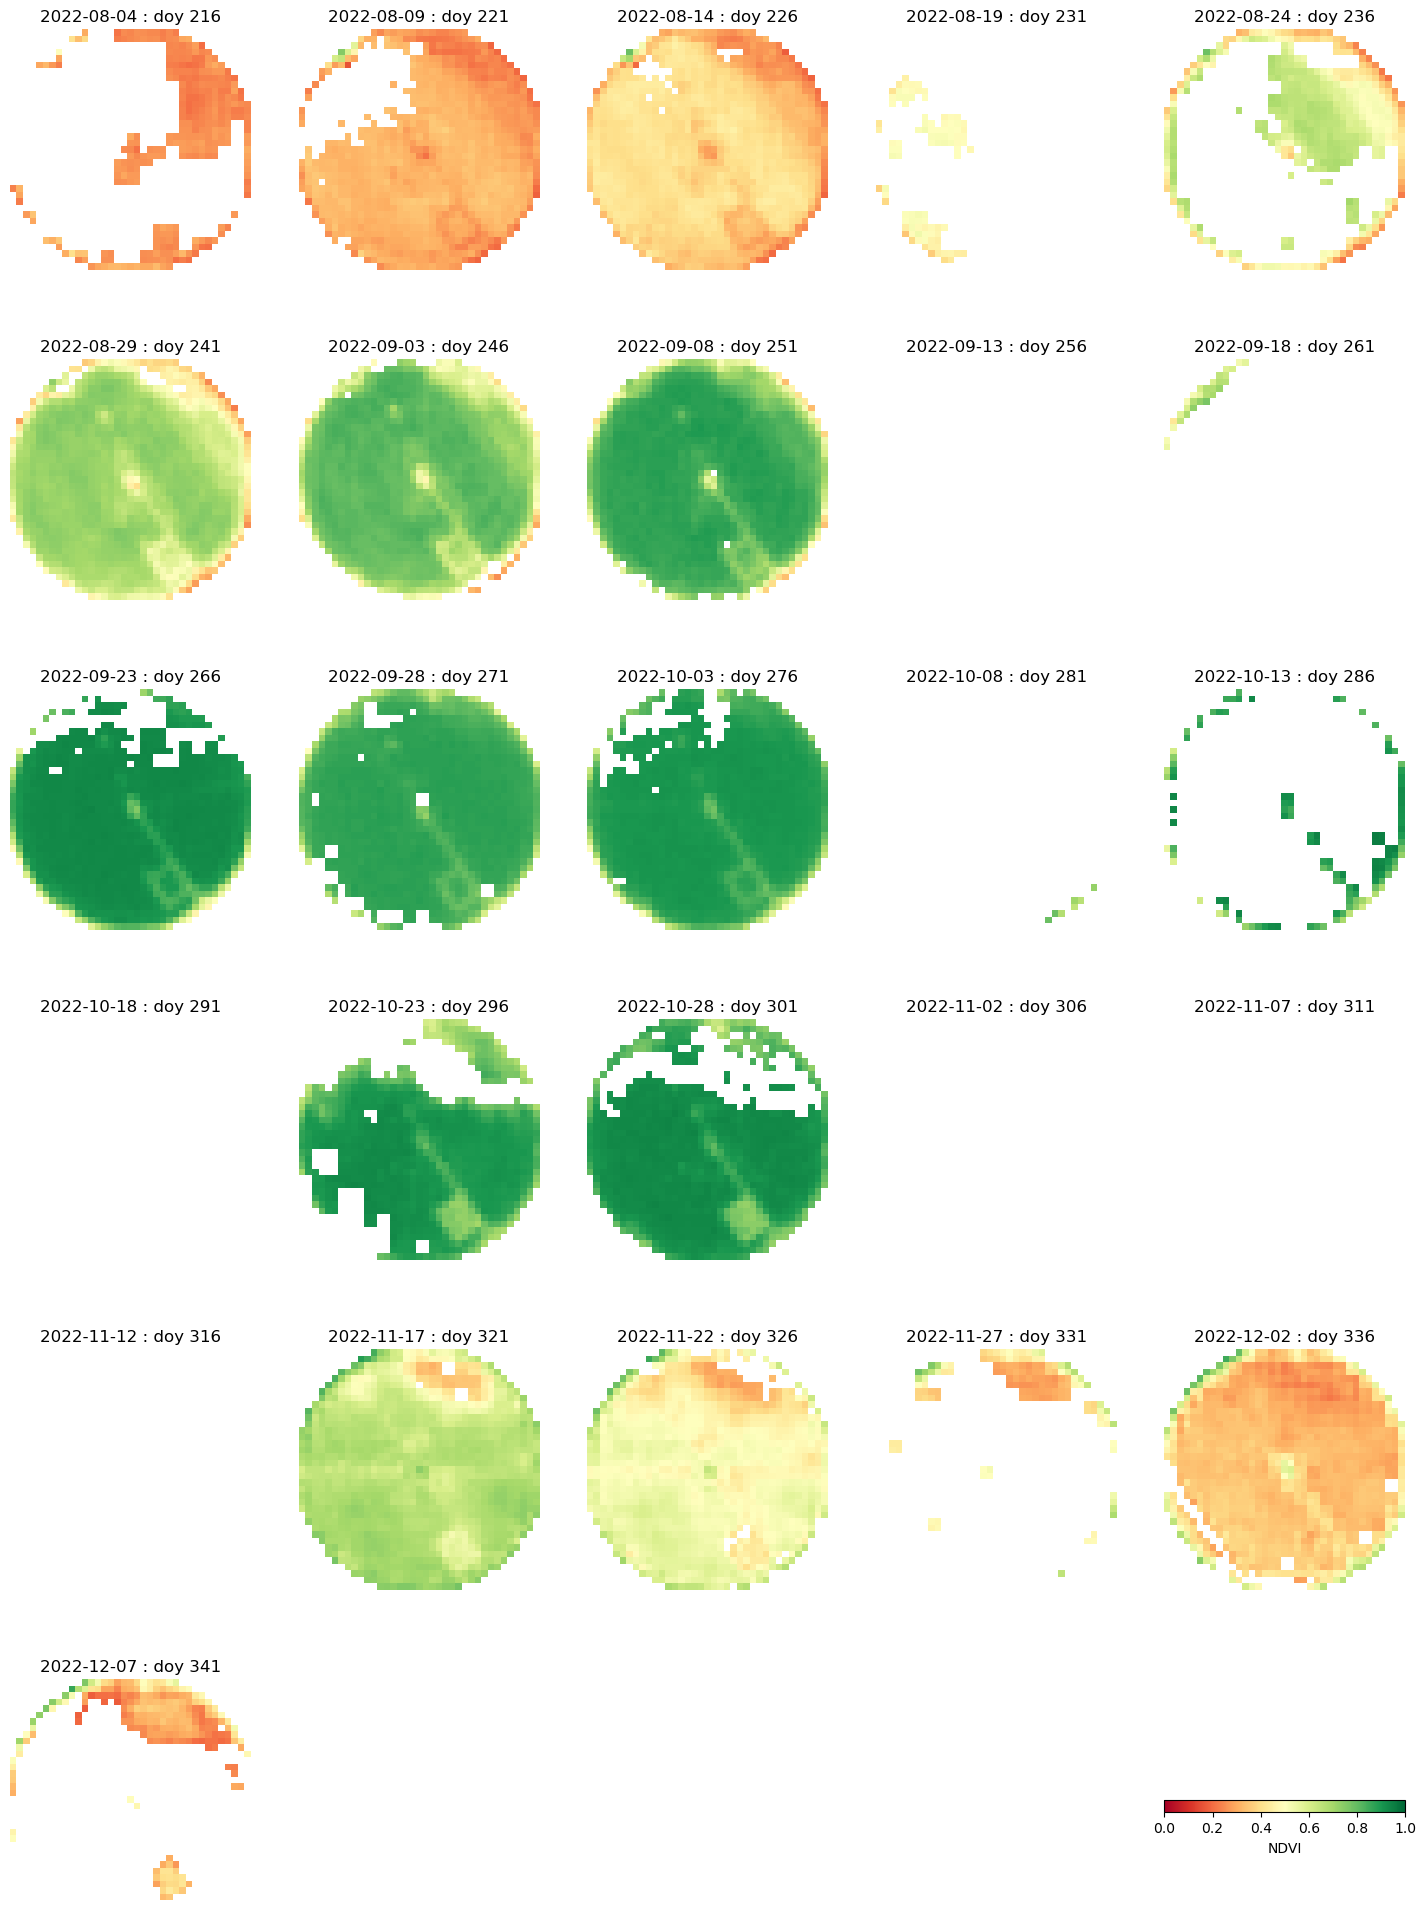

In [60]:
from arc.s2_data_reader import get_s2_official_data

# plot geojson_path data
S2_data_folder = Path.home() / f"Downloads/{Path(geojson_path).stem}"
S2_data_folder.mkdir(parents=True, exist_ok=True)

s2_refs, s2_uncs, s2_angles, doys, mask, geotransform, crs = \
        get_s2_official_data(start_date, end_date, geojson_path, S2_data_folder=S2_data_folder)

ndvi = (s2_refs[:, 7] - s2_refs[:, 2]) / (s2_refs[:, 7] + s2_refs[:, 2])
fig, axs = plt.subplots(ny, nx , figsize=(ny*3, nx*5))
axs = axs.ravel()
for i in range(nx*ny): axs[i].imshow(ndvi[0]*np.nan)

for i in range(nx*ny):
    try:
        im = axs[i].imshow(ndvi[i], cmap='RdYlGn', vmin=0, vmax=1)
        # plot colorbar
        date = str(datetime.datetime(year, 1, 1) + datetime.timedelta(days=int(doys[i]) - 1)).split()[0]
        axs[i].set_title(f'{date} : doy {doys[i]}')
    except:
        pass
    axs[i].axis('off')

cbar = fig.colorbar(im, ax=axs[nx*ny-1], orientation='horizontal', fraction=0.5)
cbar.set_label('NDVI')

The target field achieves a maximum NDVI of around 0.5, and is much lower in the main, which indicates low LAI. This is in keeping with field observations that the rain-fed field suffered from some water deficiency and only a low LAI was reached.

We see from this that there are 9 or 10 samples that cover the field over the season, with other observation dates masked for cloud and cloud shadow. 

The data are obtained from Google Earth Engine and processed to surface reflectance, using the `ARC` function `get_s2_official_data()`. 

## 2.2 Wider area NDVI


To see this field in context, we can visualise the surrounding area as well:

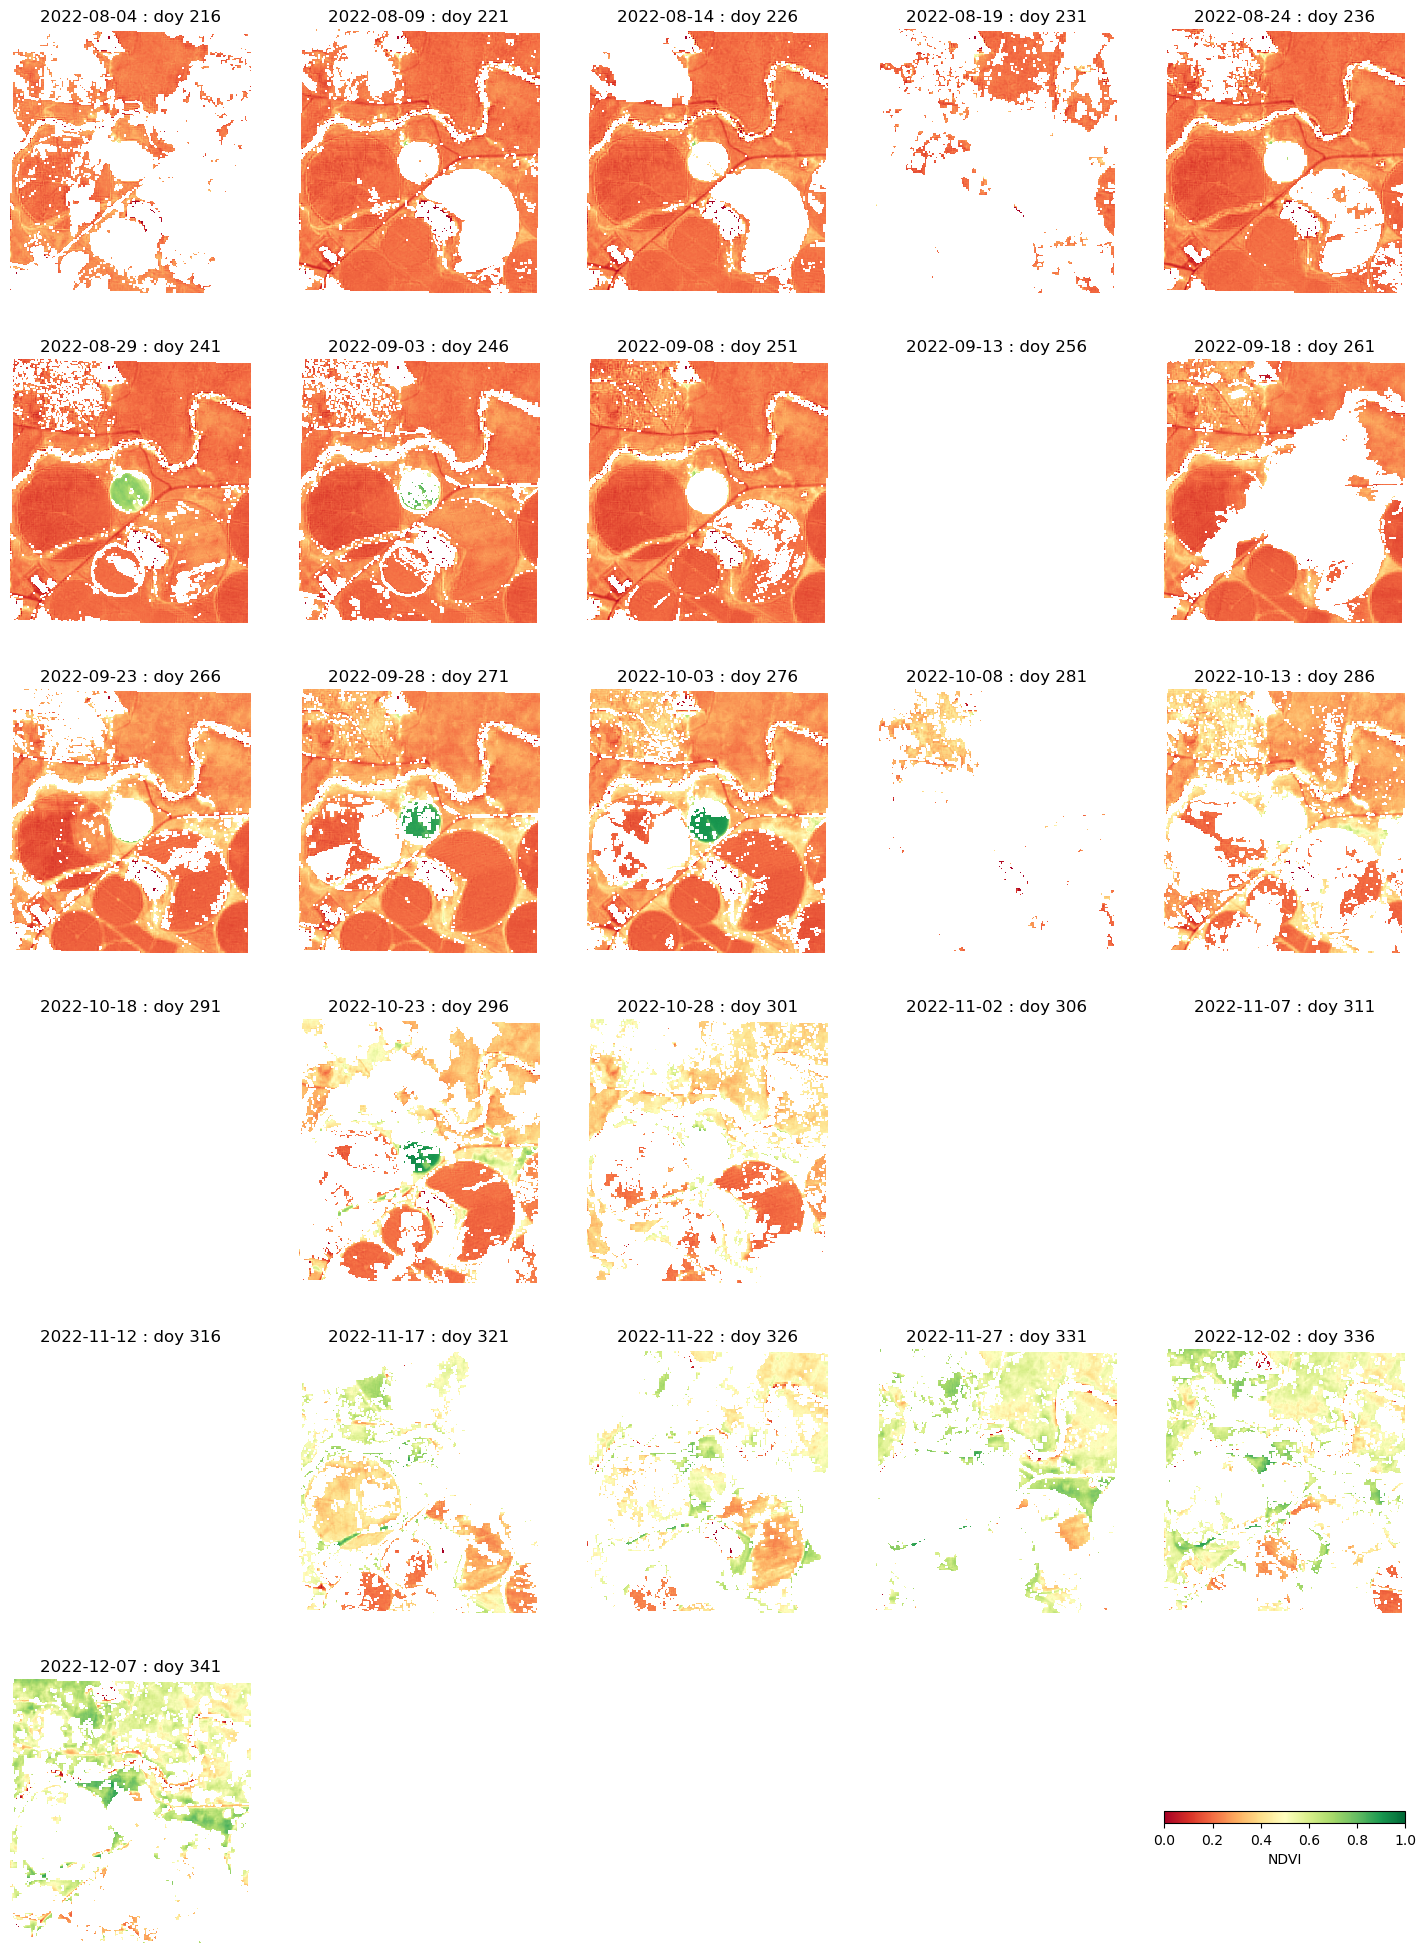

In [61]:
# plot wider_geojson data
S2_data_folder = Path.home() / f"Downloads/{Path(wider_geojson).stem}"
S2_data_folder.mkdir(parents=True, exist_ok=True)

s2_refs, s2_uncs, s2_angles, doys, mask, geotransform, crs = \
    get_s2_official_data(start_date, end_date, wider_geojson, S2_data_folder=S2_data_folder)
ndvi = (s2_refs[:, 7] - s2_refs[:, 2]) / (s2_refs[:, 7] + s2_refs[:, 2])
fig, axs = plt.subplots(ny, nx , figsize=(ny*3, nx*5))
axs = axs.ravel()
# blank
for i in range(nx*ny): axs[i].imshow(ndvi[0]*np.nan)
# data plot
for i in range(nx*ny):
    try:
        im = axs[i].imshow(ndvi[i], cmap='RdYlGn', vmin=0, vmax=1)
        date = str(datetime.datetime(year, 1, 1) + datetime.timedelta(days=int(doys[i]) - 1)).split()[0]
        axs[i].set_title(f'{date} : doy {doys[i]}')
    except:
        pass
    axs[i].axis('off')

cbar = fig.colorbar(im, ax=axs[nx*ny-1], orientation='horizontal', fraction=0.5)
_=cbar.set_label('NDVI')

## 2.2 Wider area RGB


and in True Colour (RGB):

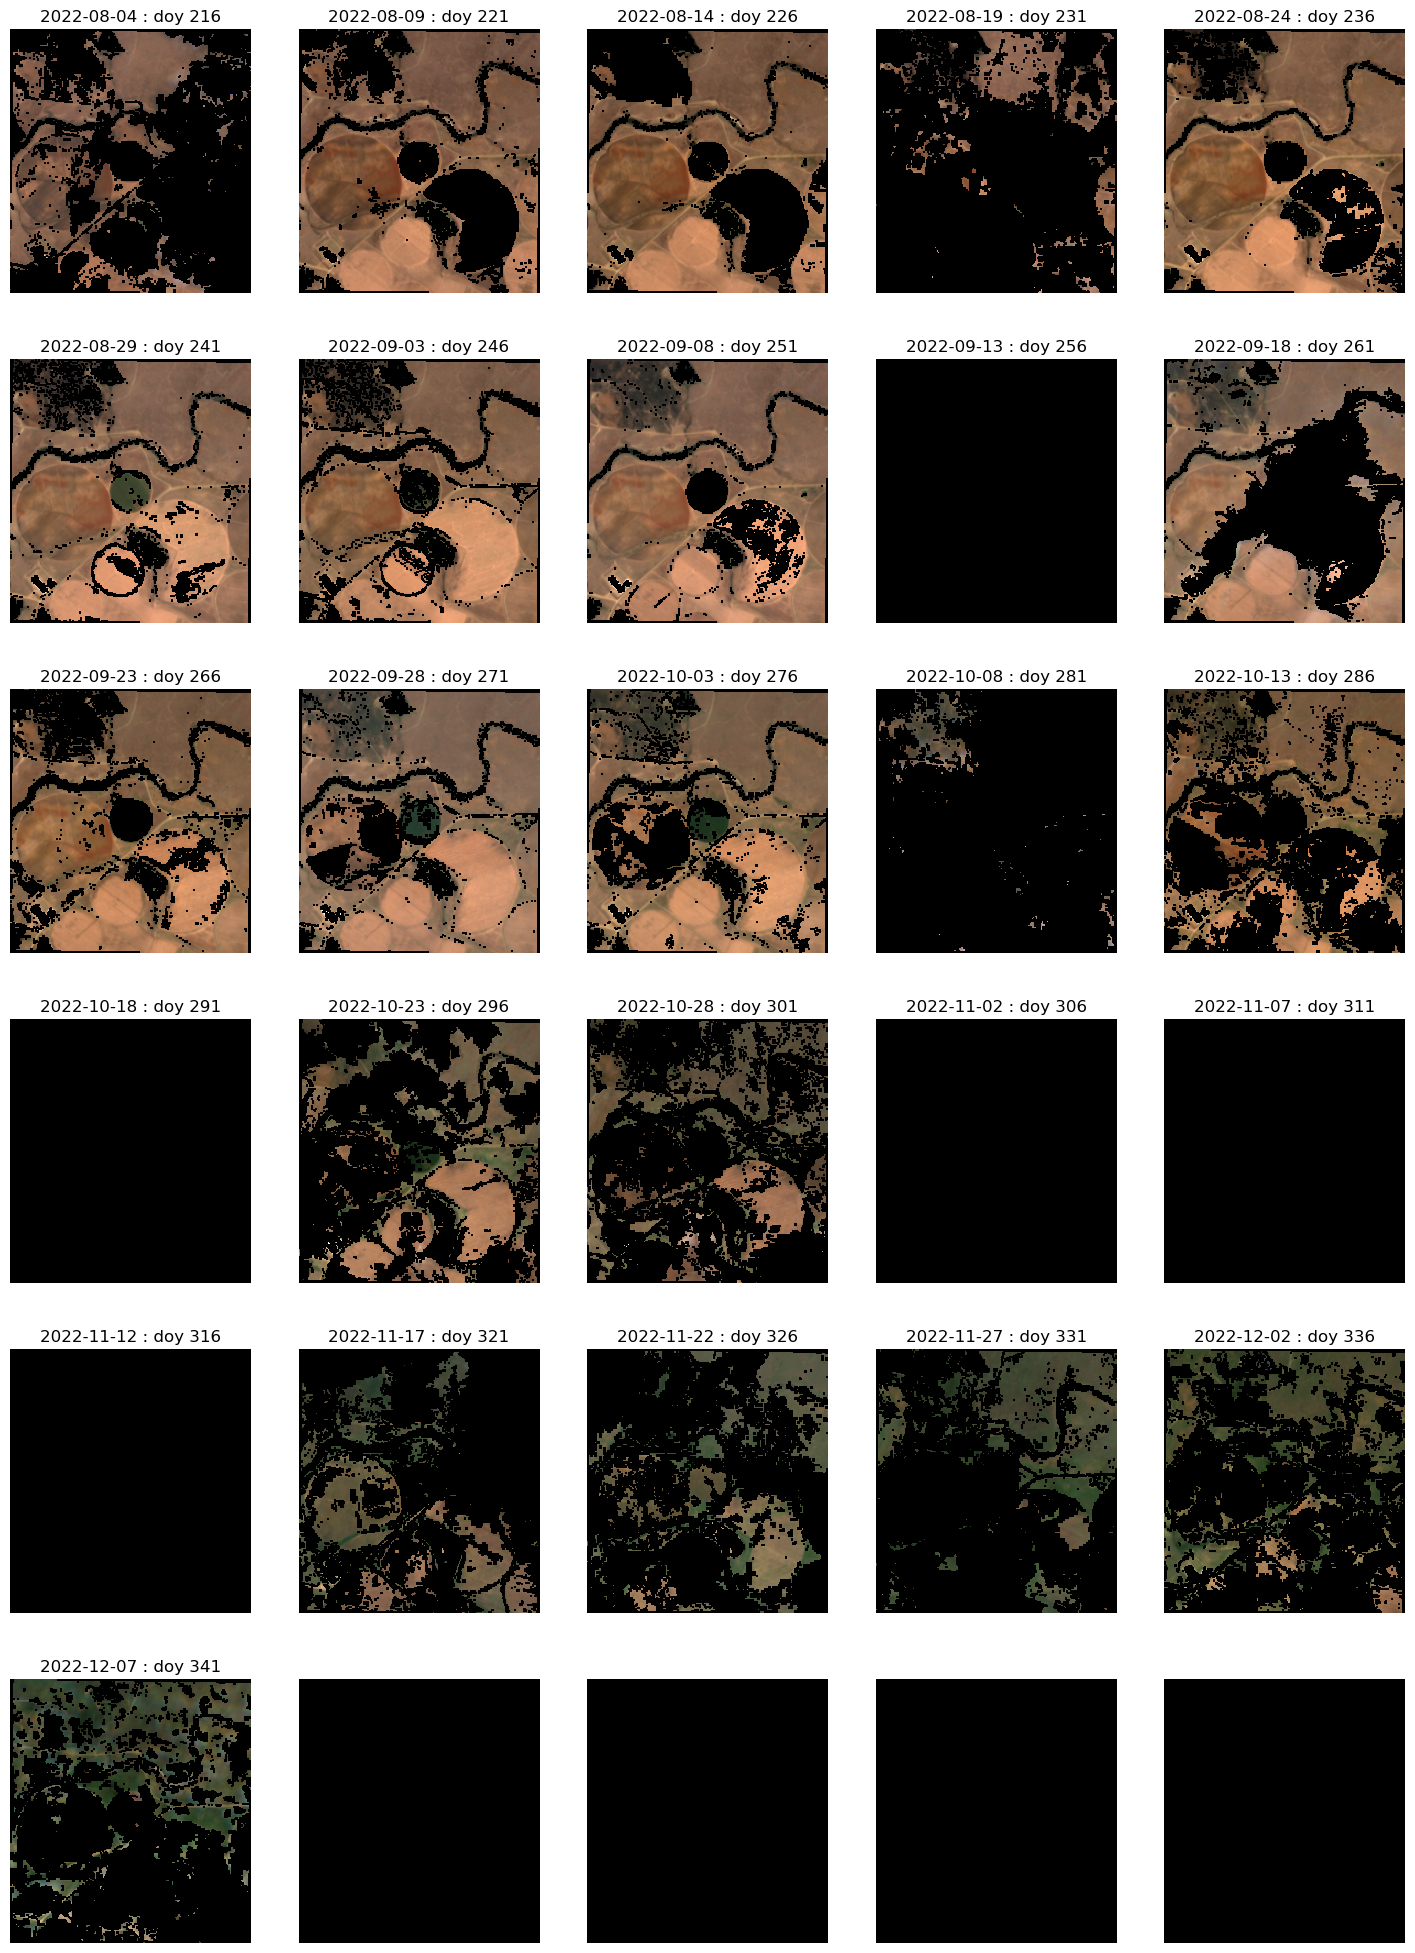

In [62]:
# plot wider_geojson data
S2_data_folder = Path.home() / f"Downloads/{Path(wider_geojson).stem}"
S2_data_folder.mkdir(parents=True, exist_ok=True)

s2_refs, s2_uncs, s2_angles, doys, mask, geotransform, crs = \
        get_s2_official_data(start_date, end_date, wider_geojson, S2_data_folder=S2_data_folder)
ndvi = (s2_refs[:, 7] - s2_refs[:, 2]) / (s2_refs[:, 7] + s2_refs[:, 2])
fig, axs = plt.subplots(ny, nx , figsize=(ny*3, nx*5))
axs = axs.ravel()
# blank
for i in range(nx*ny): axs[i].imshow(s2_refs[0, [2, 1, 0], :, :].transpose((1, 2, 0))*np.nan)
# data plot
for i in range(nx*ny):
    try:
        rgb = 4 *s2_refs[i, [2, 1, 0], :, :].transpose((1, 2, 0))
        rgb[rgb>1]=1;
        im = axs[i].imshow(rgb)
        date = str(datetime.datetime(year, 1, 1) + datetime.timedelta(days=int(doys[i]) - 1)).split()[0]    
        axs[i].set_title(f'{date} : doy {doys[i]}')
    except:
        pass
    axs[i].axis('off')

We can also visualise the dataset as RBG images. AGain, we can see that the target field is mostly quite brown, and certainly hads lower LAI than the field just to the North of the target.

If we visualise the NDVI for all field samples over time, we see a gradual increase in LAI (thence LAI) 

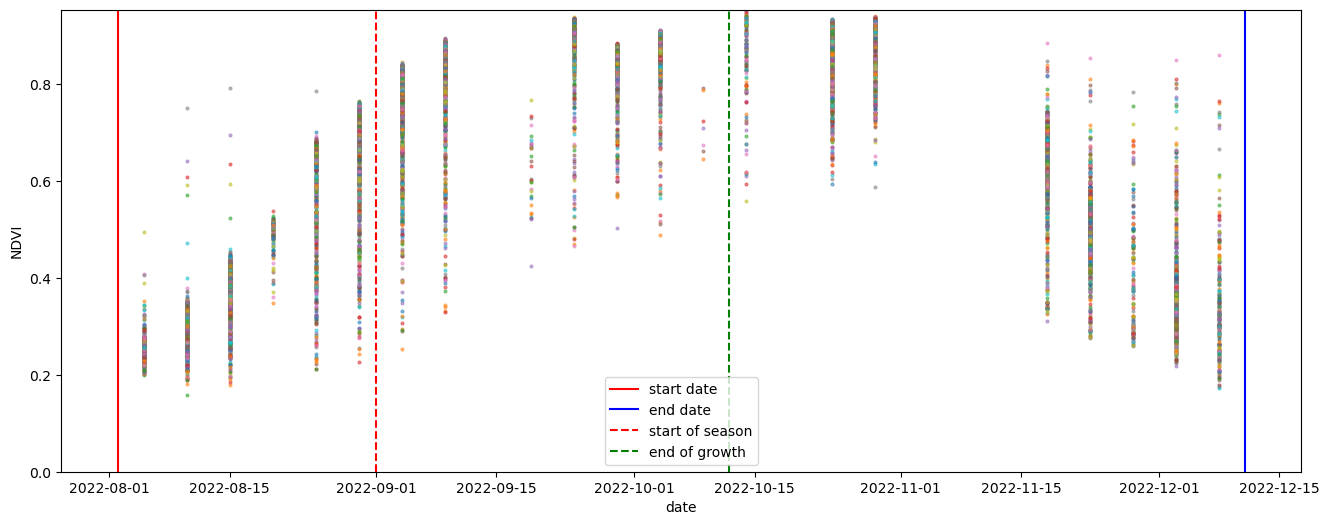

In [63]:
# plot geojson_path data
S2_data_folder = Path.home() / f"Downloads/{Path(geojson_path).stem}"
S2_data_folder.mkdir(parents=True, exist_ok=True)

s2_refs, s2_uncs, s2_angles, doys, mask, geotransform, crs = \
        get_s2_official_data(start_date, end_date, geojson_path, S2_data_folder=S2_data_folder)
ndvi = (s2_refs[:, 7] - s2_refs[:, 2]) / (s2_refs[:, 7] + s2_refs[:, 2])
ndvi_max = np.nanmax(ndvi)

# plot all samples over time
plt.figure(figsize=(16, 6))
plt.plot([datetime.datetime(year, 1, 1) + datetime.timedelta(days=int(doy)) \
              for doy in doys], ndvi.reshape(len(doys), -1)[:, ::], 'o', markersize=2, alpha=0.5)
plt.ylim(0,ndvi_max)
plt.ylabel('NDVI')
plt.xlabel('date')

t0s = datetime.datetime(year, 1, 1) + datetime.timedelta(days=int(t0))
t1s = datetime.datetime(year, 1, 1) + datetime.timedelta(days=int(t1))
t0a = datetime.datetime(year, 1, 1) + datetime.timedelta(days=int(START_OF_SEASON))
t1a = datetime.datetime(year, 1, 1) + datetime.timedelta(days=int(START_OF_SEASON+GROWTH_SEASON_LENGTH))

plt.plot([t0s,t0s],[0,ndvi_max],'r',label='start date')
plt.plot([t1s,t1s],[0,ndvi_max],'b',label='end date')

plt.plot([t0a,t0a],[0,ndvi_max],'r--',label='start of season')
plt.plot([t1a,t1a],[0,ndvi_max],'g--',label='end of growth')
_=plt.legend()

The wider area is a more complex mixture:

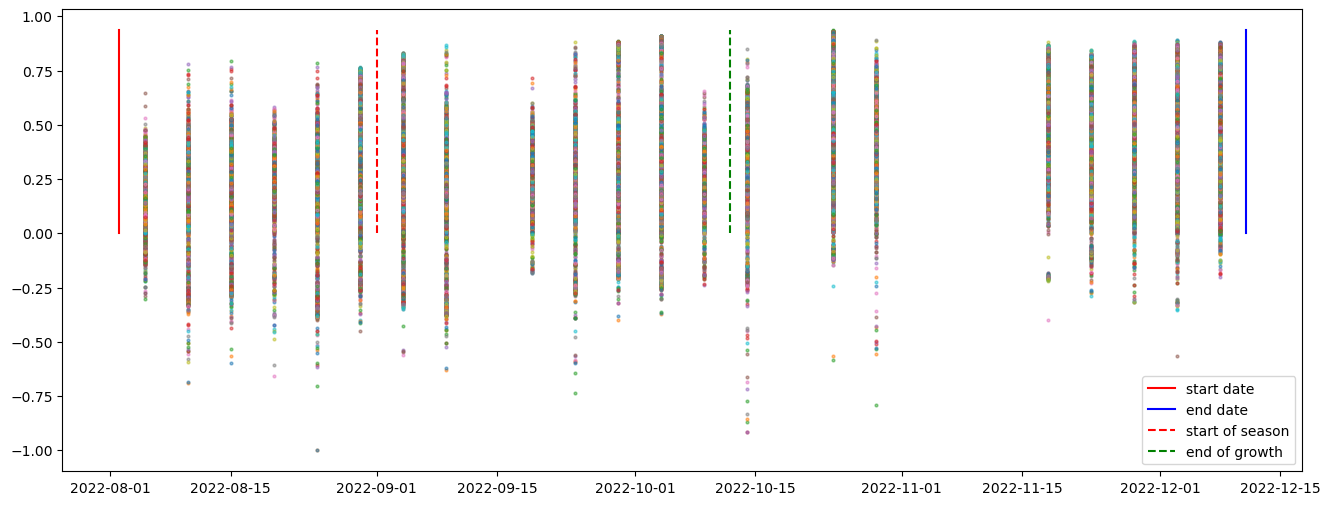

In [64]:
# plot wider_geojson data
S2_data_folder = Path.home() / f"Downloads/{Path(wider_geojson).stem}"
S2_data_folder.mkdir(parents=True, exist_ok=True)


s2_refs, s2_uncs, s2_angles, doys, mask, geotransform, crs \
        = get_s2_official_data(start_date, end_date, wider_geojson, S2_data_folder=S2_data_folder)
ndvi = (s2_refs[:, 7] - s2_refs[:, 2]) / (s2_refs[:, 7] + s2_refs[:, 2])
ndvi_max = np.nanmax(ndvi)

plt.figure(figsize=(16, 6))
_ = plt.plot([datetime.datetime(year, 1, 1) + datetime.timedelta(days=int(doy)) \
              for doy in doys], ndvi.reshape(len(doys), -1)[:, ::], 'o', markersize=2, alpha=0.5)

t0s = datetime.datetime(year, 1, 1) + datetime.timedelta(days=int(t0))
t1s = datetime.datetime(year, 1, 1) + datetime.timedelta(days=int(t1))
t0a = datetime.datetime(year, 1, 1) + datetime.timedelta(days=int(START_OF_SEASON))
t1a = datetime.datetime(year, 1, 1) + datetime.timedelta(days=int(START_OF_SEASON+GROWTH_SEASON_LENGTH))

plt.plot([t0s,t0s],[0,ndvi_max],'r',label='start date')
plt.plot([t1s,t1s],[0,ndvi_max],'b',label='end date')

plt.plot([t0a,t0a],[0,ndvi_max],'r--',label='start of season')
plt.plot([t1a,t1a],[0,ndvi_max],'g--',label='end of growth')
_=plt.legend()


# 3 Running ARC
 
 
## ARC parameters

We now proceed to run the ARC code toi estimate the archeytpe model parameters from the S2 observations, for each pixel, fitting to the time series of S2 reflectances. The method is described in Feng et al. (2024).

The user can expore various parameters here in the notebook:

    START_OF_SEASON = 243
    CROP_TYPE = "wheat"
    NUM_SAMPLES = 1000000
    GROWTH_SEASON_LENGTH = 41
    LAZY_EVALUATION_STEP = 100
    start_date = "2022-08-01"
    end_date = "2022-12-10"

We have previously defined all of these above but you could modify those again here for convenience. 

We process the local area, defined in `geojson_path`:

In [ ]:
import arc

# Constants
#START_OF_SEASON = 243
#CROP_TYPE = "wheat"
#NUM_SAMPLES = 1000000
#GROWTH_SEASON_LENGTH = 45
#LAZY_EVALUATION_STEP = 100
# dates
#start_date = "2022-08-01"
#end_date = "2022-12-10"
print('START_OF_SEASON',START_OF_SEASON)
print('CROP_TYPE',CROP_TYPE)
print('NUM_SAMPLES',NUM_SAMPLES)
print('GROWTH_SEASON_LENGTH',GROWTH_SEASON_LENGTH)
print('LAZY_EVALUATION_STEP',LAZY_EVALUATION_STEP)
print('start_date',start_date)
print('end_date',end_date)

# Alternative Constants
#CROP_TYPE = "maize"
#NUM_SAMPLES = 2000000



def main():
    """Main function to execute the Arc field processing and plotting"""

    S2_data_folder = Path.home() / f"Downloads/{Path(geojson_path).stem}"
    S2_data_folder.mkdir(parents=True, exist_ok=True)

    scale_data, post_bio_tensor, post_bio_unc_tensor, mask, doys = arc.arc_field(
        start_date,
        end_date,
        geojson_path,
        START_OF_SEASON,
        CROP_TYPE,
        f"{S2_data_folder}/{Path(geojson_path).stem}.npz",
        NUM_SAMPLES,
        GROWTH_SEASON_LENGTH,
        str(S2_data_folder),
        plot=True,
    )

    plot_lai_over_time(doys, post_bio_tensor)
    plot_lai_maps(doys, post_bio_tensor, mask)
    return scale_data, post_bio_tensor, post_bio_unc_tensor, mask, doys


def plot_lai_over_time(doys: np.array, post_bio_tensor: np.array):
    """Plot LAI over time"""
    # plotting params
    ALPHA = 0.8
    LINE_WIDTH = 2

    plt.figure(figsize=(12, 6))
    plt.plot(
        doys,
        post_bio_tensor[
            ::LAZY_EVALUATION_STEP,
            4,
        ].T
        / 100,
        "-",
        lw=LINE_WIDTH,
        alpha=ALPHA,
    )
    plt.ylabel("LAI (m2/m2)")
    plt.xlabel("Day of year")
    plt.show()


def plot_lai_maps(doys: np.array, post_bio_tensor: np.array, mask: np.array):
    """Plot LAI maps"""

    lai = post_bio_tensor[:, 4].T / 100
    laimax = int(np.nanmax(lai))
    nrows = int(len(doys) / 5) + int(len(doys) % 5 > 0)
    fig, axs = plt.subplots(ncols=5, nrows=nrows, figsize=(20, 4 * nrows))
    axs = axs.ravel()

    for i in range(len(doys)):
        lai_map = np.zeros(mask.shape) * np.nan
        lai_map[~mask] = lai[i]
        im = axs[i].imshow(lai_map, vmin=0, vmax=laimax)
        fig.colorbar(im, ax=axs[i], shrink=0.8, label="LAI (m2/m2)")
        axs[i].set_title("DOY: %d" % doys[i])
    lai_max = np.max(lai)
    # remove empty plots
    for i in range(len(doys), len(axs)):
        axs[i].axis("off")
    plt.plot([t0s,t0s],[0,lai_max],'r',label='start date')
    plt.plot([t1s,t1s],[0,lai_max],'b',label='end date')

    plt.plot([t0a,t0a],[0,lai_max],'r--',label='start of season')
    plt.plot([t1a,t1a],[0,lai_max],'g--',label='end of growth')
    plt.show()


if __name__ == "__main__":
    scale_data, post_bio_tensor, post_bio_unc_tensor, mask, doys = main()

START_OF_SEASON 243
CROP_TYPE wheat
NUM_SAMPLES 1000000
GROWTH_SEASON_LENGTH 41
LAZY_EVALUATION_STEP 100
start_date 2022-08-01
end_date 2022-12-10


The ARC function we use here `arc.arc_field()` calculates the solution, and if `plot=True` will also illustrate the optimal set of ensemble reflectance members (blue lines) and observations (red dots). You should check that that ensemble set covers the observations. That means that there is a good match between the ensemble modelled reflectance and the measurements, so we should ber able to robustly estimate the canopy biophysical parameters.

The reflectance plots are laid out to show reflectance per S2 waveband over time for a number of pixel samples. You should be able to see whether or not the ensembles cover the reflectance at each waveband. If not, then consider changing the parameters, e.g. the season start or end or the number of ensemble samnples.

There is also a plot of sample LAI trajectories over time. We observe that maximum LAI seems to be reached around DOY 300 (October 27th). We can check if this is a sensible interpretation by looking at the exploratory data above.

An image of the spatial LAI interpretation is also shown. Again, we can see the maximum LAI occurring around DOY 300. We notice quite a large variation in apparent LAI over the field, with the south-western portion of the field having maximum LAI of greater that 2, butr other parts of the field barely reaching an LAI of 1 or 1.5 perhaps.

# 4 Leaf Area Index results

We now run some codes to explore the results for LAI. We extract these from the `samplefile`.

In [ ]:
features = geojson.load(open(samplefile, 'r'))['features']
geoms = []
coords = []
for feature in features:
    
    coord = feature['geometry']['coordinates']
    coords.append(coord[:2])
    
    geom = geometry.Point(coord)
    geoms.append(geom)
_=geometry.GeometryCollection(geoms)

In [ ]:
arc_dir = os.path.dirname(os.path.realpath(arc.__file__))
S2_data_folder = Path.home() / f"Downloads/{Path(geojson_path).stem}"
S2_data_folder.mkdir(parents=True, exist_ok=True)
output_file = f"{S2_data_folder}/{Path(geojson_path).stem}.npz"
f = np.load(output_file)

geotransform = tuple(f.f.geotransform.tolist())
crs = str(f.f.crs)

from pyproj import Transformer
transformer = Transformer.from_crs("EPSG:4326", crs, always_xy=True)
Tcoords = [i for i in transformer.itransform(coords)]

Acoords = np.array([[(i[0] - geotransform[0]) / geotransform[1], (i[1] - geotransform[3]) \
                     / geotransform[5]] for i in Tcoords]).astype(int)

In [ ]:
s2_lai = post_bio_tensor[:, 4]
s2_cab = post_bio_tensor[:, 1]

temp = np.zeros(mask.shape + (s2_lai.shape[1], ))
temp[~mask] = s2_lai
s2_lai = temp

temp = np.zeros(mask.shape + (s2_cab.shape[1], ))
temp[~mask] = s2_cab
s2_cab = temp

We can visualise the 5 sample locations, with 5 white crosses in the image below indicating the sub-sampling. For each of the 5 sample plots, we apply a buffer of e.g. `buffer_n = 3` i.e. a +/- 3 10m pixels around each sample location, so the samples cover around 70 m x 70 m. 

The base image shows the maximum LAI per pixel, confirming the observation above from NDVI that the LAI is higher in the lower left iof the field.

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols = 1, figsize=(20,10))
ax = axs
ax.set_title('Maximum predicted LAI, showing sample locations',fontsize=12)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
mm = np.max(s2_lai,axis=2)/100.
laimax = int(np.nanmax(mm))+1
mm[mm==0] = np.nan

all_data = []
im = ax.imshow(mm,vmin=0,vmax=laimax)
fig.colorbar(im, cax=cax, orientation='vertical')

# plot sample areas
for i in range(1, 6):
    c =[]
    data = []
    for j in range(1, 6):
        for feature in features:
            field_id = feature['properties']['Name']
            if field_id == f'P{i}S{j}':
                coord = feature['geometry']['coordinates'][:2]
                geom = geometry.Point(coord)
                
                Tcoord = transformer.transform(coord[0], coord[1])
                Acoord = (Tcoord[0] - geotransform[0]) / geotransform[1], \
                        (Tcoord[1] - geotransform[3]) / geotransform[5]
                Acoord = np.round(np.array(Acoord)).astype(int) 
                #print(Acoord[1], Acoord[0],np.max(s2_lai[Acoord[1], Acoord[0]]/100.))
                c.append([Acoord[1], Acoord[0]])
                
                lai = feature['properties']['LAI_measurement']
                # cab = feature['properties']['Cab_measurement']
                
                data.append(lai)
    all_data.append(data)
    mask = np.max(s2_lai,axis=2)>0
    
    omask = mask.copy()
    
    c = np.array(c)
    for cc in c:
        for k in range(-buffer_n,buffer_n+1):
            for j in range(-buffer_n,buffer_n+1):
                try:
                    mask[cc[0]+k,cc[1]+j] = 0
                except:
                    pass
    mask = omask * ~mask
    ax.contour(mask)
    y,x = np.round(c.mean(axis=0)).astype(int)
    ax.text(x-4,y, f'sample {i}', color="red", fontsize=12)
    ax.plot(c.T[1],c.T[0],'w+')

ax.set_axis_off()

In [ ]:
import datetime
import geojson
from shapely import geometry
import pylab as plt


features = geojson.load(open(samplefile, 'r'))['features']
geoms = []

# generate date fields for satellite observations
s2_dates = [datetime.datetime(year, 1, 1) + datetime.timedelta(days=int(i-1)) for i in doys]
# interpolate to target dates
sample_dates = np.array([int(d.strftime("%j")) for d in s2_dates])

fig, axs = plt.subplots(nrows=5, ncols = 1, figsize=(16, 40))
axs = axs.ravel()

all_target_s2_pred = []
all_data = []
for i in range(1, 6):
    ax = axs[i-1]
    c =[]
    data = []
    for j in range(1, 6):
        for feature in features:
            field_id = feature['properties']['Name']
            if field_id == f'P{i}S{j}':
                coord = feature['geometry']['coordinates'][:2]
                geom = geometry.Point(coord)
                
                Tcoord = transformer.transform(coord[0], coord[1])
                Acoord = (Tcoord[0] - geotransform[0]) / geotransform[1], \
                    (Tcoord[1] - geotransform[3]) / geotransform[5]
                Acoord = np.round(np.array(Acoord)).astype(int) 
                #print(Acoord[1], Acoord[0],np.max(s2_lai[Acoord[1], Acoord[0]]/100.))
                c.append([Acoord[1], Acoord[0]])
                
                lai = feature['properties']['LAI_measurement']
                # cab = feature['properties']['Cab_measurement']
                
                data.append(lai)
                dates = [datetime.datetime.strptime(i, '%Y%m%d') \
                         for i in feature['properties']['measurement_dates']]
                target_dates = np.array([int(d.strftime("%j")) for d in dates])

    all_data.append(data)
    mask = np.max(s2_lai,axis=2)>0
    omask = mask.copy()
    
    
    
    #plt.imshow(np.max(s2_lai,axis=2)/100.)
    #plt.imshow(mask)
    #plt.colorbar()
    # buffer +/-n pixels
    
    c = np.array(c)
    for cc in c:
        for k in range(-buffer_n,buffer_n+1):
            for j in range(-buffer_n,buffer_n+1):
                try:
                    mask[cc[0]+k,cc[1]+j] = 0
                except:
                    pass
    mask = omask * ~mask
    # max measured for plot
    meas_max = np.round(np.max(np.max(data,axis=0)))
    
    _=ax.plot(dates, np.mean(data,axis=0).T,'r',lw=2)
    _=ax.plot(dates, np.mean(data,axis=0).T,'ro',label='mean observed LAI')
    _=ax.plot(dates, np.mean(data,axis=0).T + np.std(data,axis=0).T,'r--',label='+/- 1 sd observed LAI')
    _=ax.plot(dates, np.mean(data,axis=0).T - np.std(data,axis=0).T,'r--')

    _=ax.plot(dates, np.min(data,axis=0),'r-',lw=0.5,label='min/max observed LAI')
    _=ax.plot(dates, np.max(data,axis=0),'r-',lw=0.5)
    ax.plot(s2_dates,np.mean(s2_lai[mask]/100.,axis=0),'k-',lw=2)
    ax.plot(s2_dates,np.mean(s2_lai[mask]/100.,axis=0),'ko',label='mean predicted LAI')

    ax.plot(s2_dates,np.mean(s2_lai[mask]/100.,axis=0)+np.std(s2_lai[mask]/100.,axis=0),\
            'k--',label='+/- 1 sd predicted LAI')
    ax.plot(s2_dates,np.mean(s2_lai[mask]/100.,axis=0)-np.std(s2_lai[mask]/100.,axis=0),\
            'k--')

    ax.plot(s2_dates,np.min(s2_lai[mask]/100.,axis=0),'k-',lw=0.5,label='min/max predicted LAI')
    ax.plot(s2_dates,np.max(s2_lai[mask]/100.,axis=0),'k-',lw=0.5)
    ax.set_xlabel('date')
    ax.set_ylabel('LAI $(m^2/m^2)$')
    ax.set_title(f'location sample {i}',fontsize=12)
    ymax = np.max([laimax,meas_max])
    ax.set_ylim(0,ymax)
    
    # interpolate to target dates
    target_s2_pred = np.array([np.interp(target_dates,sample_dates,d) for d in (s2_lai[mask]/100.)]).T
    _=ax.plot(dates,np.mean(target_s2_pred,axis=1),'k+')
    all_target_s2_pred.append(target_s2_pred)
    
        
    ax.plot([t0s,t0s],[0,ymax],'r',label='start date')
    ax.plot([t1s,t1s],[0,ymax],'b',label='end date')

    ax.plot([t0a,t0a],[0,ymax],'r--',label='start of season')
    ax.plot([t1a,t1a],[0,ymax],'g--',label='end of growth')
    ax.legend()


The plots above visualise the observed (red) and predicted (black) patterns of LAI over time. The 9 field observations are shown as red dots. The LAI predicted from S2 using ARC is calculated at regular intervals (black dots). 

The results show a clear under-estimation of LAI in the S2 ARC results that is quite consistent over time. Sample 5 seems generally clioser to the observations than the other samples.  

If we plot the measured and S2-ARC-modelled data together for each of the 5 sample locations and 9 time periods, we can see how well the model predicts the (independent) LAI observations. 

In [ ]:

# plot limit
m = laimax
mean_pred = np.array([np.mean(d,axis=1) for d in all_target_s2_pred])
mean_obs = np.mean(all_data,axis=0)
std_pred = np.array([np.std(d,axis=1) for d in all_target_s2_pred])
std_obs = np.std(all_data,axis=0)

plt.figure(figsize=(6,6))
plt.errorbar(mean_obs.ravel(),mean_pred.ravel(),std_obs.ravel(),std_pred.ravel(),'k.')
plt.plot(mean_obs,mean_pred,'bo')

plt.plot([0.,m],[0.,m],'r--')
plt.xlabel('observed LAI ($m^2/m^2$)')
plt.ylabel('S2-predicted LAI ($m^2/m^2$)')

plt.xlim(0,m)
plt.ylim(0,m)

from scipy.stats import linregress
slope, intercept, r, p, se = linregress(mean_obs.ravel(),mean_pred.ravel())

plt.title(f'{year} validation results\n\ny = ({intercept:.2} + {slope:.2} * x); '+\
          f' R = {r:.2};\n\nN = 45;   p = {p:.2};   se = {se:.2}\n')
plt.plot([0.,m],[intercept,intercept+slope*m],'k--',\
         label=f'regression line')

plt.plot(mean_obs[0],mean_pred[0],'bo',label='lai ($m^2/m^2$)')

_=plt.legend()

np.savez(f'data/{TAG}_lai.npz',mean_pred=mean_pred,mean_obs=mean_obs,std_pred=std_pred,std_obs=std_obs)



The plot shows S2-ARC-predicted LAI (y-axis) against observed LAI (x-axis) for the 5 x 9 (N=45) samples. The LAI mean samples over the 5 sub-locations for observations and over the buffer areas shown above are used to calculate mean and standard deviation. The mean is shown as the blue dot, with +/- 1 standard deviation shown as the error bars. 

The regression shows a strong linear relationship (R=0.88) between LAI predicted from S2 compared to ground observations for 2022. But there is an apparent bias of -0.24 and a slope of 0.7, i.e. the S2-predictions under-predict the actual LAI. Most of the piints lie around the regression line, but there seems to be a cluster of outliers that are closer to the 1:1 line. Those points are mainly from the last time sample taken, which can be confirmed looking at the time plots above.

# 5 Chlorophyll results

We now examine the results for Chlorophyll (Cab), following the same approach as above:


In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, axs = plt.subplots(nrows=1, ncols = 1, figsize=(20,10))
#axs = axs.ravel()
ax = axs
ax.set_title('Maximum predicted Cab, showing sample locations',fontsize=12)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
mm = np.max(s2_cab,axis=2)/100.
cabmax = int(np.nanmax(mm)/10+1)*10
mm[mm==0] = np.nan
im = ax.imshow(mm,vmin=0,vmax=cabmax)
fig.colorbar(im, cax=cax, orientation='vertical')
for i in range(1, 6):
    c =[]
    data = []
    for j in range(1, 6):
        for feature in features:
            field_id = feature['properties']['Name']
            if field_id == f'P{i}S{j}':
                coord = feature['geometry']['coordinates'][:2]
                geom = geometry.Point(coord)
                
                Tcoord = transformer.transform(coord[0], coord[1])
                Acoord = (Tcoord[0] - geotransform[0]) / geotransform[1], \
                    (Tcoord[1] - geotransform[3]) / geotransform[5]
                Acoord = np.round(np.array(Acoord)).astype(int) 
                #print(Acoord[1], Acoord[0],np.max(s2_lai[Acoord[1], Acoord[0]]/100.))
                c.append([Acoord[1], Acoord[0]])
                
                lai = feature['properties']['Cab_measurement']
                # cab = feature['properties']['Cab_measurement']
                
                data.append(lai)
    all_data.append(data)
    mask = np.max(s2_cab,axis=2)>0
    omask = mask.copy()
    
    
    #plt.imshow(np.max(s2_lai,axis=2)/100.)
    #plt.imshow(mask)
    #plt.colorbar()
    # buffer +/-n pixels
    
    c = np.array(c)
    for cc in c:
        for k in range(-buffer_n,buffer_n+1):
            for j in range(-buffer_n,buffer_n+1):
                try:
                    mask[cc[0]+k,cc[1]+j] = 0
                except:
                    pass
    mask = omask * ~mask
    ax.contour(mask)
    y,x = np.round(c.mean(axis=0)).astype(int)
    ax.text(x-4,y, f'sample {i}', color="red", fontsize=12)
    ax.plot(c.T[1],c.T[0],'w+')

ax.set_axis_off()

The maximum Chlorophyll concentration (Cab) predicted by ARC with S2 data is quite consistent over the field, with values around 70 $\mu g / cm^2$.

In [ ]:


features = geojson.load(open(samplefile, 'r'))['features']
geoms = []

s2_dates = [datetime.datetime(year, 1, 1) + datetime.timedelta(days=int(i-1)) for i in doys]

# interpolate to target dates
sample_dates = np.array([int(d.strftime("%j")) for d in s2_dates])


fig, axs = plt.subplots(nrows=5, ncols = 1, figsize=(16, 40))
axs = axs.ravel()

all_target_s2_pred = []
all_data = []
for i in range(1, 6):
    ax = axs[i-1]
    c =[]
    data = []
    for j in range(1, 6):
        for feature in features:
            field_id = feature['properties']['Name']
            if field_id == f'P{i}S{j}':
                coord = feature['geometry']['coordinates'][:2]
                geom = geometry.Point(coord)
                
                Tcoord = transformer.transform(coord[0], coord[1])
                Acoord = (Tcoord[0] - geotransform[0]) / geotransform[1], \
                        (Tcoord[1] - geotransform[3]) / geotransform[5]
                Acoord = np.round(np.array(Acoord)).astype(int) 
                c.append([Acoord[1], Acoord[0]])
                
                lai = feature['properties']['Cab_measurement']
                
                data.append(lai)
                dates = [datetime.datetime.strptime(i, '%Y%m%d') \
                        for i in feature['properties']['measurement_dates']]
                target_dates = np.array([int(d.strftime("%j")) for d in dates])

    all_data.append(data)
    mask = np.max(s2_cab,axis=2)>0
    omask = mask.copy()
    
    
    meas_max = np.round(np.max(np.max(data,axis=0)))
    
    c = np.array(c)
    for cc in c:
        for k in range(-buffer_n,buffer_n+1):
            for j in range(-buffer_n,buffer_n+1):
                try:
                    mask[cc[0]+k,cc[1]+j] = 0
                except:
                    pass
    mask = omask * ~mask

    _=ax.plot(dates, np.mean(data,axis=0).T,'r',lw=2)
    _=ax.plot(dates, np.mean(data,axis=0).T,'ro',label='mean observed Cab')
    _=ax.plot(dates, np.mean(data,axis=0).T + np.std(data,axis=0).T,'r--',label='+/- 1 sd observed Cab')
    _=ax.plot(dates, np.mean(data,axis=0).T - np.std(data,axis=0).T,'r--')

    _=ax.plot(dates, np.min(data,axis=0),'r-',lw=0.5,label='min/max observed Cab')
    _=ax.plot(dates, np.max(data,axis=0),'r-',lw=0.5)
    ax.plot(s2_dates,np.mean(s2_cab[mask]/100.,axis=0),'k-',lw=2)
    ax.plot(s2_dates,np.mean(s2_cab[mask]/100.,axis=0),'ko',label='mean predicted Cab')

    ax.plot(s2_dates,np.mean(s2_cab[mask]/100.,axis=0)+np.std(s2_lai[mask]/100.,axis=0),'k--',\
            label='+/- 1 sd predicted Cab')
    ax.plot(s2_dates,np.mean(s2_cab[mask]/100.,axis=0)-np.std(s2_lai[mask]/100.,axis=0),'k--')

    ax.plot(s2_dates,np.min(s2_cab[mask]/100.,axis=0),'k-',lw=0.5,label='min/max predicted Cab')
    ax.plot(s2_dates,np.max(s2_cab[mask]/100.,axis=0),'k-',lw=0.5)
    ax.set_xlabel('date')
    ax.set_ylabel('Cab $\mu g / cm^2$')
    ax.set_title(f'location sample {i}',fontsize=12)
    ymax = np.max([cabmax,meas_max])
    ax.set_ylim(0,ymax)
    
    # interpolate to target dates
    target_s2_pred = np.array([np.interp(target_dates,sample_dates,d) for d in (s2_cab[mask]/100.)]).T
    _=ax.plot(dates,np.mean(target_s2_pred,axis=1),'k+')
    all_target_s2_pred.append(target_s2_pred)
    ax.legend()
     
    ax.plot([t0s,t0s],[0,ymax],'r',label='start date')
    ax.plot([t1s,t1s],[0,ymax],'b',label='end date')

    ax.plot([t0a,t0a],[0,ymax],'r--',label='start of season')
    ax.plot([t1a,t1a],[0,ymax],'g--',label='end of growth')
    ax.legend()


We now find that the Cab concentration is over-estimated by the ARC method here. The timimg of the peak of Cab is quite similar for all samples, although the peak from ARC seems slightly earlier than the peak for the measurements. 

In [ ]:

# plot limit
m = cabmax

mean_pred = np.array([np.mean(d,axis=1) for d in all_target_s2_pred])
mean_obs = np.mean(all_data,axis=0)
std_pred = np.array([np.std(d,axis=1) for d in all_target_s2_pred])
std_obs = np.std(all_data,axis=0)

plt.figure(figsize=(6,6))
plt.errorbar(mean_obs.ravel(),mean_pred.ravel(),std_obs.ravel(),std_pred.ravel(),'k.')
plt.plot(mean_obs,mean_pred,'bo')

plt.plot([0.,m],[0.,m],'r--')
plt.xlabel('observed Cab ($\mu g/cm^2$)')
plt.ylabel('S2-predicted Cab ($\mu g/cm^2$)')

plt.xlim(0,m)
plt.ylim(0,m)

from scipy.stats import linregress
slope, intercept, r, p, se = linregress(mean_obs.ravel(),mean_pred.ravel())

plt.title(f'{year} validation results\n\ny = ({intercept:.2f} + {slope:.2} * x); '+\
          f'  R = {r:.2};\n\nN = 45;   p = {p:.2};   se = {se:.2}\n')
plt.plot([0.,m],[intercept,intercept+slope*m],'k--',\
         label=f'regression line')

plt.plot(mean_obs[0],mean_pred[0],'bo',label='Cab ($\mu g/cm^2$)')

_=plt.legend()

# save data
np.savez(f'data/{TAG}_cab.npz',mean_pred=mean_pred,mean_obs=mean_obs,std_pred=std_pred,std_obs=std_obs)


The validation for 2022 indicates a bias of around 16 $\mu g / cm^2$ in the S2 predictions, but the slope is very close to unity. 

# 6 Summary

In summary, we have perfomed a comparison of field-measured LAI and Cab over a rain-fed wheat field with estimsates of those biophysical parameters obtained from the ARC method. Observations were taken at 9 times over the season in 2022. There is a similar number of satellite observations that cover the field from cloud-free Sentinel-2 MSI data.

The approach is able to find a solution for ensemble estimates of reflectance in all S2 wavebands, and make consistent spatial and temporal estimates of LAI and Cab (and other biophysical variables, see Feng et al., 2024). When compared to field observations, the S2 ARC estimates appear to cover the same temporal pattern as the ground observations, although the peak in values for the S2 estimates is slightly early compared to the field data. That could be an issue with not having sufficient samples of S2 at appropriate times. The LAI has a bias of 0.24, which is quite low, but a slope of around 0.7, showing a consistent under-0estimate with respect to the field LAI data. For Cab, there is a simple bias of around 16 $\mu g / cm^2$ in the S2 estimates.


All of the data and codes for users running their own experiments along the same lines as this are provided in this notebook. There is a similar mortebook and dataset for data from an irrigated wheat field measured in 2022.